In [1]:
%load_ext autotime
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.extend(["../"])

time: 988 µs


In [3]:
from sklearn.model_selection import train_test_split
from core.tools.data_import import *
from core.tools.time_series import *
from constants import *

time: 394 ms


In [4]:
from pprint import pprint
pprint(UNRATE_DIR)
file_dir_selected = input("Select Directory ")

{'EC2': '/home/ec2-user/code/AnnEconForecast/data/UNRATE.csv',
 'MAC': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv'}
Select Directory MAC
time: 2.17 s


In [37]:
df = load_dataset(UNRATE_DIR[file_dir_selected])
df_d1 = differencing(df, periods=1, order=1)
LAGS = 48

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64
time: 25.8 ms


In [38]:
X_raw, y_raw = gen_supervised_rnn(df_d1, LAGS)

time: 94.1 ms


In [39]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=False
)

time: 3.82 ms


In [40]:
# Expand dimension so it fits the RNN input place holder.
# (Num_Sample, )
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_val = np.expand_dims(X_val, axis=2)

y_train = np.expand_dims(y_train, axis=2)
y_test = np.expand_dims(y_test, axis=2)
y_val = np.expand_dims(y_val, axis=2)

time: 1.9 ms


In [41]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (512, 48, 1)
y_train shape: (512, 48, 1)
X_test shape: (160, 48, 1)
y_test shape: (160, 48, 1)
X_validation shape: (128, 48, 1)
y_validation shape: (128, 48, 1)
time: 1.63 ms


In [56]:
num_time_steps = LAGS
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_neurons = 64
# Number of output series
num_outputs = 1
learning_rate = 0.3
epochs = 1000
batch_size = 1

time: 1.65 ms


In [57]:
# THIS IS REAL
size_train = 24*28 + 1
train = df_d1[:size_train]
test = df_d1[size_train:]
print(train.shape)
print(test.shape)

(673, 1)
(177, 1)
time: 2.08 ms


In [58]:
tf.reset_default_graph()
# setting up
X = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_inputs],
    name="Input_placeholder")
y = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_outputs],
    name="Output_placeholder")

time: 4.64 ms


In [59]:
# Build RNN.
cell = tf.contrib.rnn.LSTMCell(
    num_units=num_neurons
)
    
rnn_output, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
stacked_rnn_output = tf.reshape(rnn_output, [-1, num_neurons])

stacked_outputs = tf.layers.dense(stacked_rnn_output, num_outputs)
outputs = tf.reshape(stacked_outputs, [-1, num_time_steps, num_outputs])

# last_output = outputs[:, -1, :]

time: 127 ms


In [60]:
num_neurons

64

time: 2.12 ms


In [61]:
# Operators
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

time: 370 ms


In [62]:
y

<tf.Tensor 'Output_placeholder:0' shape=(?, 48, 1) dtype=float32>

time: 2.92 ms


In [63]:
hist = {"train": [], "val": []}
with tf.Session() as sess:
    sess.run(init)
    for e in range(epochs):
        sess.run(train,
                 feed_dict={X: X_train, y: y_train})
        if e % 10 == 0:
            train_mse = loss.eval(feed_dict={X: X_train, y: y_train})
#             print(f"Iteratin [{e}]: Training MSE {train_mse}")
            val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
            hist["train"].append(train_mse)
            hist["val"].append(val_mse)
            print(f"Iteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}")
    
    gen_pred = lambda src: outputs.eval(feed_dict={X: src})[:,-1]
    p_train = gen_pred(X_train)
    p_test = gen_pred(X_test)
    

Iteration [0], Training MSE 0.0485293; Validation MSE 0.0186983
Iteration [10], Training MSE 0.0481677; Validation MSE 0.0186908
Iteration [20], Training MSE 0.0478424; Validation MSE 0.0186280
Iteration [30], Training MSE 0.0475470; Validation MSE 0.0185741
Iteration [40], Training MSE 0.0472789; Validation MSE 0.0185285
Iteration [50], Training MSE 0.0470353; Validation MSE 0.0184902
Iteration [60], Training MSE 0.0468137; Validation MSE 0.0184586
Iteration [70], Training MSE 0.0466115; Validation MSE 0.0184329
Iteration [80], Training MSE 0.0464264; Validation MSE 0.0184125
Iteration [90], Training MSE 0.0462564; Validation MSE 0.0183969
Iteration [100], Training MSE 0.0460995; Validation MSE 0.0183856
Iteration [110], Training MSE 0.0459543; Validation MSE 0.0183781
Iteration [120], Training MSE 0.0458193; Validation MSE 0.0183740
Iteration [130], Training MSE 0.0456932; Validation MSE 0.0183729
Iteration [140], Training MSE 0.0455749; Validation MSE 0.0183745
Iteration [150], Trai

In [64]:
# clean = lambda x: np.squeeze(x[:, -1: ])
# pred_train = clean(pred_train)
# pred_val = clean(pred_val)
# pred_test = clean(pred_test)
y_test.shape

(160, 48, 1)

time: 2.41 ms


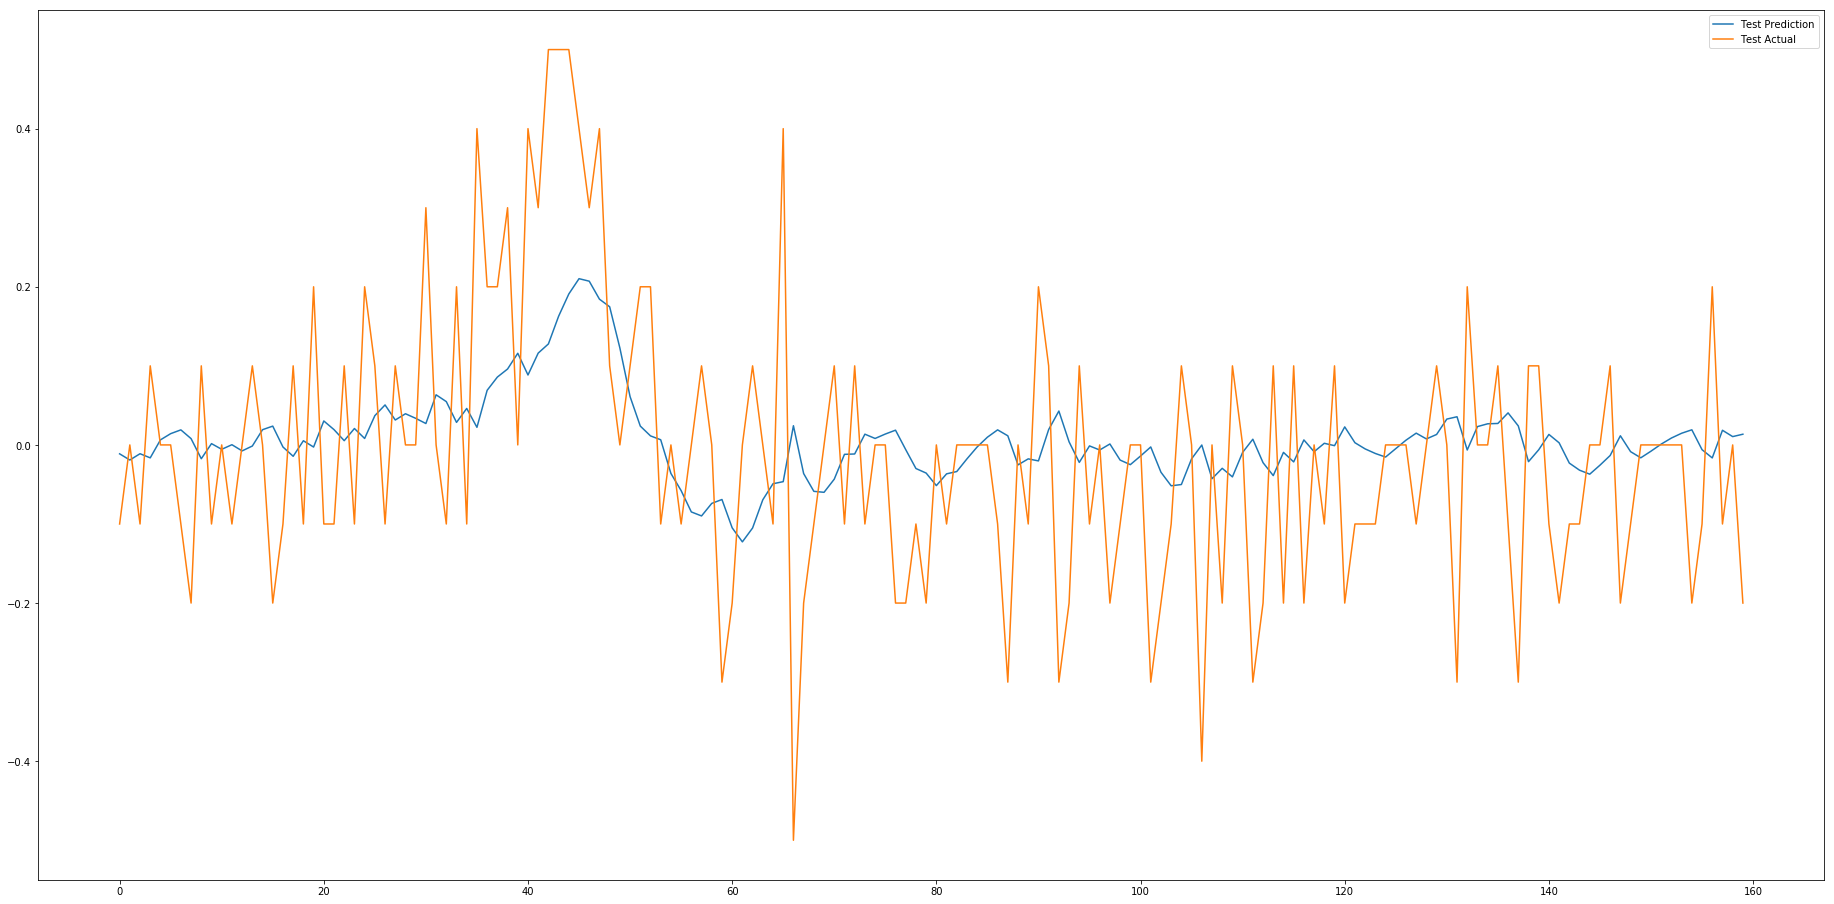

time: 904 ms


In [65]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_test))
plt.plot(np.squeeze(y_test[:,-1]))
plt.legend(["Test Prediction", "Test Actual"])
pl
plt.show()

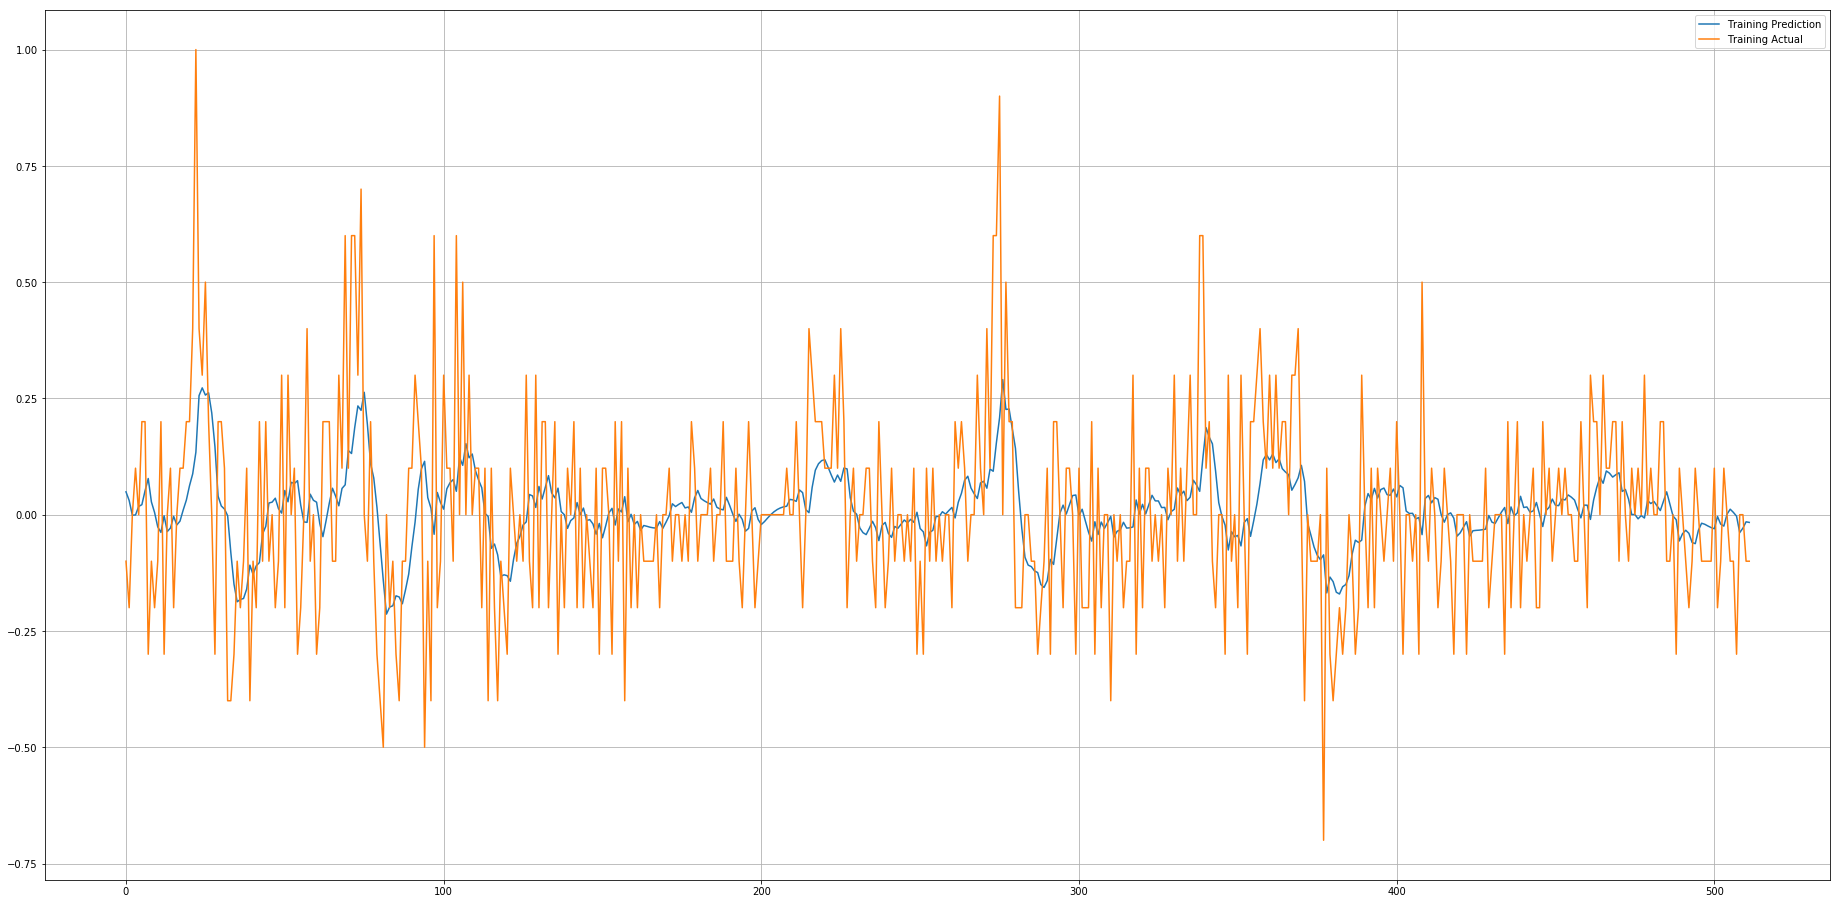

time: 1.16 s


In [69]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_train))
plt.plot(np.squeeze(y_train[:,-1]))
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.show()

In [ ]:
plt.close()
plt.plot(np.log(hist["train"]))
plt.plot(np.log(hist["val"]))
plt.legend(["Log Training Loss", "Log Validation Loss"])
plt.show()